<a href="https://colab.research.google.com/github/mphipps2/SemanticSegmentation_SAR_Images/blob/main/v2_UNet_AsymUnifiedFocalLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis Outline

**1.   [Load Libraries, Dataset, and Routines](#Load)**

**2.   [Dataset Exploration](#Explore_Data)**

- How many images/masks do we have? <font color='red'>790 of each</font> 
- What do images and masks look like?
- How many from each class in dataset? <font color='red'>
  - Background: 40,654,521 pixels <font color='red'>(98.15%)</font>
  - Seep 1: 428,563 pixels <font color='red'>(1.03%)</font>
  - Seep 2: 49,491 pixels <font color='red'>(0.12%)</font>
  - Seep 3: 18,677 pixels <font color='red'>(0.05%)</font>
  - Seep 4: 35,942 pixels <font color='red'>(0.09%)</font>
  - Seep 5: 130,601 pixels <font color='red'>(0.32%)</font>
  - Seep 6: 93,978 pixels <font color='red'>(0.23%</font>
  - Seep 7: 6,979 pixels <font color='red'>(0.02%)</font>


- How frequently does an image have an empty mask? <font color='red'>only 2 images with no seeps</font> 

**3.    [Preprocessing](#Preprocessing)**

**4.    [Partition Data: Train/Validation/Test](#Partition)**

**5.    [Data Augmentation](#Data_Augmentation)**

**6.    [One Hot Encode the Masks](#One-Hot-Encode)**

**7.    [Define Model: Multi-Class U-Net](#Model)**

**8.    [Training](#Training)**

**9.    [Performance Assessment](#Assessment)**


<a name="Load"></a>
##1. Load Libraries, Dataset and Routines

In [1]:
#Load libraries

import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import os
import sys
import random
from datetime import datetime
from google.colab import drive
drive.mount('/content/gdrive')

# image processing
import glob
import cv2

# tensorflow 
#from tensorboard.plugins.hparams import api as hp

#from tensorflow.contrib.training import HParams
from tensorflow.python.keras.utils.data_utils import Sequence, is_generator_or_sequence
!pip install tensorflow-addons
import tensorflow_addons as tfa
# needed for tensorboard
from tensorflow.python.keras.callbacks import TensorBoard
import datetime

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, Input,  Dropout, Lambda, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

# sklearn
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# visualization
from itertools import cycle, product
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# preprocessing 
#from scipy.ndimage import gaussian_filter
from scipy import ndimage as nd
from skimage.filters import sobel, meijering, sato

# data augmentation
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate, RandomRotate90, Transpose

# metrics
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, auc
from keras.metrics import MeanIoU

# keras extensions for segmentation-based models, losses, and metrics
from tensorflow import keras
!pip install keras-applications==1.0.8
!pip install efficientnet 
!pip install segmentation_models
#import segmentation_models as sm

# unified focal loss function
# if this is the first time running, clone the following library:
#%cd /content/gdrive/My Drive/Seep_Project/
#!git clone https://github.com/mphipps2/unified-focal-loss.git
ROOT_DIR = "/content/gdrive/My Drive/Seep_Project/unified-focal-loss"
sys.path.append(ROOT_DIR) 
from loss_functions import *

print('graphics card:')
!nvidia-smi

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
graphics card:
Thu Feb  3 05:13:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+---------------------

In [2]:
# Load dataset

SIZE_X = 256
SIZE_Y = 256
TOTAL_IMAGES = 790
N_CLASSES = 8
do_cleanup = True
path_img = 'gdrive/My Drive/Colab Notebooks/Data/seep_detection/train_images_256/*.tif' 
path_mask = 'gdrive/My Drive/Colab Notebooks/Data/seep_detection/train_masks_256/*.tif' 

all_img_list = []
all_mask_list = []

# first sort image and mask names to make sure their order is aligned
image_names = glob.glob(path_img)
image_names.sort()
mask_names = glob.glob(path_mask)
mask_names.sort()

for filename in image_names:
  img = cv2.imread(filename,-1)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))   
  all_img_list.append(img) 
  del img

for filename in mask_names:
  mask = cv2.imread(filename,-1)
  mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
  all_mask_list.append(mask)
  del mask
# convert list of ndarray to ndarray of ndarray
all_img = np.array(all_img_list)
all_mask = np.array(all_mask_list)

if N_CLASSES == 2:
  # in this case, all seven signal classes collapsed down to a single signal class
  all_mask = np.where(all_mask > 0, 1, 0)

print('# of training images: ', len(all_img))
print('# of training masks: ', len(all_mask))

if do_cleanup:
  del all_img_list
  del all_mask_list



# of training images:  790
# of training masks:  790


In [59]:
#Load visualization routines

def visualize_img_mask(image, mask, img_number, n_classes):

  plt.figure(figsize=(18,10))
  plt.subplot(221)
  plt.title('Image ' + str(img_number))
  plt.imshow(img, cmap='gray', vmin=0, vmax=65535)
  plt.colorbar()
  plt.subplot(222)
  plt.title('Mask ' + str(img_number))
  if n_classes == 2:
    cmap = ListedColormap(['gray', 'white'])
  else:
    cmap = 'Set2'
  plt.imshow(mask,cmap=cmap) 
  plt.clim(0,7)
  plt.colorbar()
  plt.show()


def visualize_augmentation(image, mask, original_image=None, original_mask=None):
  fontsize = 18
    
  if original_image is None and original_mask is None:
    f, ax = plt.subplots(2, 1, figsize=(8, 8))
    ax[0].imshow(image)
    ax[1].imshow(mask)
  else:
    f, ax = plt.subplots(2, 2, figsize=(8, 8))

    img_0 = ax[0, 0].imshow(original_image, cmap='gray', vmin=0, vmax=65535)
    ax[0, 0].set_title('Original image', fontsize=fontsize)
        
    ax[1, 0].imshow(original_mask,cmap='Set2')
    ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
    ax[0, 1].imshow(image, cmap='gray', vmin=0, vmax=65535)
    ax[0, 1].set_title('Augmented image', fontsize=fontsize)
        
    ax[1, 1].imshow(mask,cmap='Set2')
    ax[1, 1].set_title('Augmented mask', fontsize=fontsize)

    plt.figure(figsize=(25,18))


def visualize_pr(recall, precision, n_classes):
  colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

  plt.figure(figsize=(14, 8))
  f_scores = np.linspace(0.2, 0.8, num=4)
  lines = []
  labels = []
  for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

  lines.append(l)
  labels.append('iso-f1 curves')
  l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
  lines.append(l)
  labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision["micro"]))

  for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall')
  plt.ylabel('Precision') 
  plt.title('Precision-Recall curve to multi-class')
  plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))

  plt.show()


def plot_confusion_matrix(cm, class_names, title):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.
    
  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 6))
   
  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
   
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, aspect='auto')
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure


def visualize_img_target_pred(img, target, pred):

  fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=False,
                          figsize=(30,7))
  pcm1 = axes[0].pcolormesh(img, cmap='gray')
  # Place first colorbar on first column - index 0
  fig.colorbar(pcm1, ax=axes[0])
  pcm2 = axes[1].pcolormesh(target, cmap='Set2')
  pcm2.set_clim(0,7)
  # Place second colorbar on second column - index 1
  fig.colorbar(pcm2, ax=axes[1])
  pcm3 = axes[2].pcolormesh(pred, cmap='Set2')
  pcm3.set_clim(0,7)
  # Place second colorbar on second column - index 1
  fig.colorbar(pcm3, ax=axes[2])

  plt.show()

def visualize_img_target_pred2_pred8(img, target, pred_2, pred_8):
  fontsize = 18

  fig, axes = plt.subplots(nrows=1, ncols=4, constrained_layout=True,
                          figsize=(30,7))
  pcm1 = axes[0].pcolormesh(img, cmap='gray')
  pcm4 = axes[0].set_title('Test Img', fontsize=fontsize)
  # Place first colorbar on first column - index 0
  fig.colorbar(pcm1, ax=axes[0])
  pcm2 = axes[1].pcolormesh(target, cmap='Set2')
  pcm2 = axes[1].set_title('Target', fontsize=fontsize)
  pcm2.set_clim(0,7)
  # Place second colorbar on second column - index 1
  fig.colorbar(pcm2, ax=axes[1])
  pcm3 = axes[2].pcolormesh(pred_2, cmap='gray')
  pcm3 = axes[2].set_title('Pred: 2 Class', fontsize=fontsize)
  pcm3.set_clim(0,1)
  # Place second colorbar on second column - index 1
  fig.colorbar(pcm3, ax=axes[2])
  pcm4 = axes[3].pcolormesh(pred_8, cmap='Set2')
  pcm4 = axes[3].set_title('Pred: 8 Class', fontsize=fontsize)
  pcm4.set_clim(0,7)
  # Place second colorbar on second column - index 1
  fig.colorbar(pcm4, ax=axes[3])
  plt.show()



<a name="Explore_Data"></a>
## 2. Dataset Exploration 

Model statistics extracted and image/mask pairs visualized

In [4]:
# Dataset statistics 

print('img type: ', type(all_img), ' img shape: ', all_img.shape, ' element type: ', type(all_img[0][0][0]))
print('mask type: ', type(all_mask), ' img shape: ', all_mask.shape, ' element type: ', type(all_mask[0][0][0]))
unique, counts = np.unique(all_mask, return_counts=True)
print('Class breakdown: ' , dict(zip(unique, counts)))

# check how many images don't contain any seeps. If this is high, these could be cut from training

print('The following events do not contain seeps (ie they only contain the background class 0):')
for i, val in enumerate(all_mask):
  sum = val.sum()
  if sum == 0:
    print('i: ', i, ' sum: ', sum)

# only 2 events, so don't worry about it

img type:  <class 'numpy.ndarray'>  img shape:  (790, 256, 256)  element type:  <class 'numpy.uint16'>
mask type:  <class 'numpy.ndarray'>  img shape:  (790, 256, 256)  element type:  <class 'numpy.uint8'>
Class breakdown:  {0: 50838488, 1: 525335, 2: 64758, 3: 22489, 4: 42957, 5: 155191, 6: 116229, 7: 7993}
The following events do not contain seeps (ie they only contain the background class 0):
i:  177  sum:  0
i:  749  sum:  0


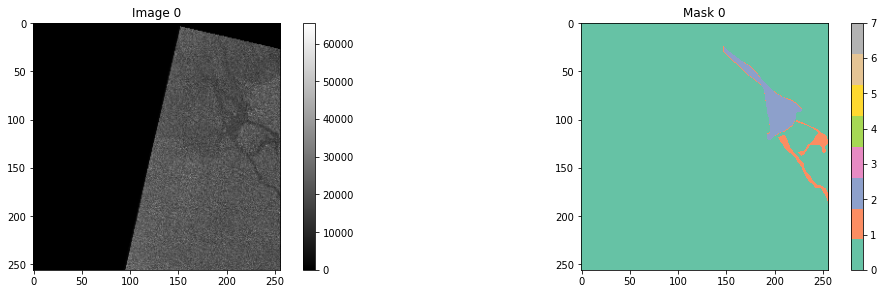

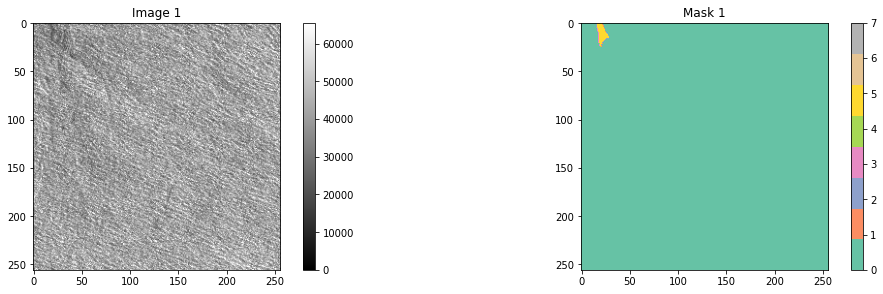

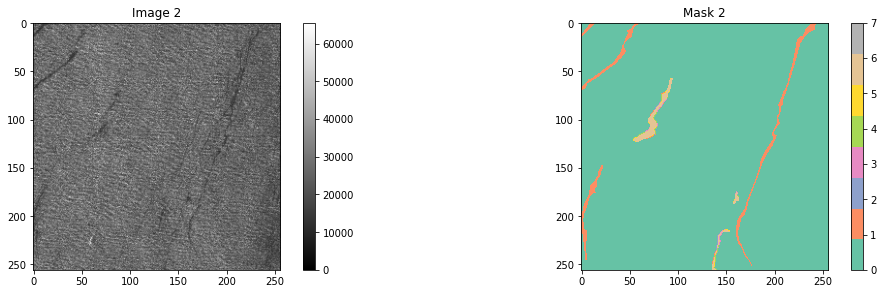

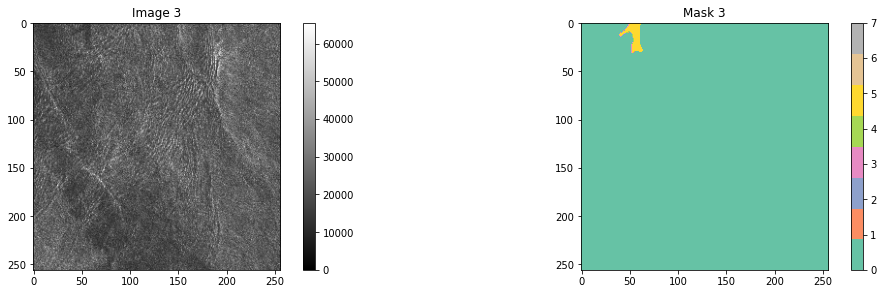

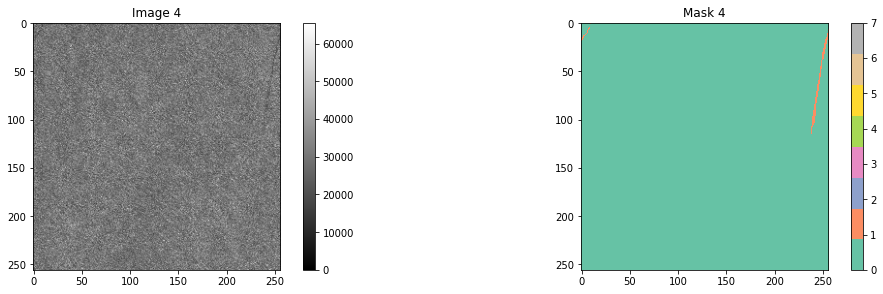

In [5]:
# Visualize random image/mask pairs

vis_n_images = 5

for i in range(vis_n_images):  
  img_number = random.randint(0, len(all_img))
  img = all_img[img_number]
  mask = all_mask[img_number]
  visualize_img_mask(img, mask, i, N_CLASSES)

<a name="Preprocessing"></a>
## 3. Preprocessing

User selection of whether to normalize image or apply a particular filter

In [4]:
# Scale input vector to unit norm: all uint64 elements become float64
doNorm = True
# Apply Filters: {0: No filter, 1: Sato, 2: Meijering, 3: Median, 4: Gaus3}
# if a filter is selected, input image array is transformed
filterNumber = 0



if doNorm:
  all_img = normalize(all_img, axis=1)

# note: black_ridges = True performs better
if filterNumber == 1: 
  temp = []
  for i in range(TOTAL_IMAGES):
    temp.append(sato(all_img[i], black_ridges = True))
  all_img = np.array(temp)
  del temp

elif filterNumber == 2:
  temp = []
  for i in range(TOTAL_IMAGES):
    temp.append(meijering(all_img[i], black_ridges = True))
  all_img = np.array(temp)
  del temp

elif filterNumber == 3:
  temp = []
  for i in range(TOTAL_IMAGES):
    temp.append(nd.median_filter(all_img[i]))
  all_img = np.array(temp)
  del temp

elif filterNumber == 4:
  temp = []
  for i in range(TOTAL_IMAGES):
    temp.append(nd.gaussian_filter(all_img[i], sigma=3))
  all_img = np.array(temp)
  del temp



<a name="Partition"></a>
## 4. Partition Data: Train/Validation/Test

In [5]:
# Using the high RAM GPU on Google Pro, my drive ends up crashing if the 8 class training ratio is above ~0.48 (with offline augmentation applied). For two class model, there are no memory constraints.
if N_CLASSES == 8:
  train_ratio = 0.48
else:
  train_ratio = 0.6

test_val_ratio = 0.5

train_x, tmp_x   = train_test_split(all_img, train_size = train_ratio, shuffle = True, random_state = 7)
val_x, test_x    = train_test_split(tmp_x, train_size = test_val_ratio, shuffle = True, random_state = 7)
train_y, tmp_y   = train_test_split(all_mask, train_size = train_ratio, shuffle = True, random_state = 7)
val_y, test_y    = train_test_split(tmp_y, train_size = test_val_ratio, shuffle = True, random_state = 7)

print('training_size: ', len(train_x), ' val_size: ', len(val_x), ' test_size: ', len(test_x))

N_TRAINING_EVENTS = train_x.shape[0]
N_TEST_EVENTS = test_x.shape[0]

IMG_HEIGHT = train_x.shape[1]
IMG_WIDTH  = train_x.shape[2]

if do_cleanup:
  del all_img
  del all_mask
  del tmp_x
  del tmp_y

training_size:  379  val_size:  205  test_size:  206


<a name="Data_Augmentation"></a>
##5. Data Augmentation:
There are eight independent representations of a single square image on a plane : the four 90 degree rotations and an axis flip for each. Each training image and its mask will be modified by these transforms, such that the final training set is 8x larger. These transforms will help the model learn abstract representations of each class that are more rotationally and translationally invariant. They'll also allows us to significantly increase the number of training events, giving the model more exposure to minority classes. Note: augmentation will only be performed on training data; validation and test data are unmodified.

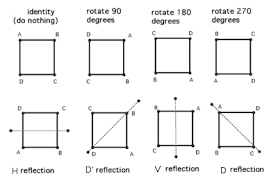

In [6]:
# Offline data augmentation
random.seed(7)

AUG = []

AUG.append( Compose([
    Rotate(limit=[90.,90.], p=1.)]))
AUG.append( Compose([
    Rotate(limit=[180.,180.], p=1.)]))
AUG.append( Compose([
    Rotate(limit=[270.,270.], p=1.)]))
AUG.append( Compose([
    VerticalFlip(p=1.)]))
AUG.append( Compose([
    VerticalFlip(p=1.),
    Rotate(limit=[90.,90.], p=1.)]))
AUG.append( Compose([
    VerticalFlip(p=1.),
    Rotate(limit=[180.,180.], p=1.)]))
AUG.append( Compose([
    VerticalFlip(p=1.),
    Rotate(limit=[270.,270.], p=1.)]))
# Identity transform: ie) original image is included as one of eight augmentations
AUG.append( Compose([]))

augmented_imgs = []
augmented_masks = []
N_LOOPS = 8

for i in range(N_LOOPS):
  for j in range(N_TRAINING_EVENTS):
    augmented = AUG[i](image=train_x[j], mask=train_y[j])
    augmented_imgs.append(augmented['image'])
    augmented_masks.append(augmented['mask'])

# reassign train_x and train_y to the new augmented images and masks

train_x = np.array(augmented_imgs)
train_y = np.array(augmented_masks)

TOTAL_IMAGES = train_x.shape[0]

print ('Img shape after augmenting', train_x.shape)
print ('Mask shape after augmenting', train_y.shape)

if do_cleanup:
  del augmented_imgs
  del augmented_masks


Img shape after augmenting (3032, 256, 256)
Mask shape after augmenting (3032, 256, 256)


Image number:  87


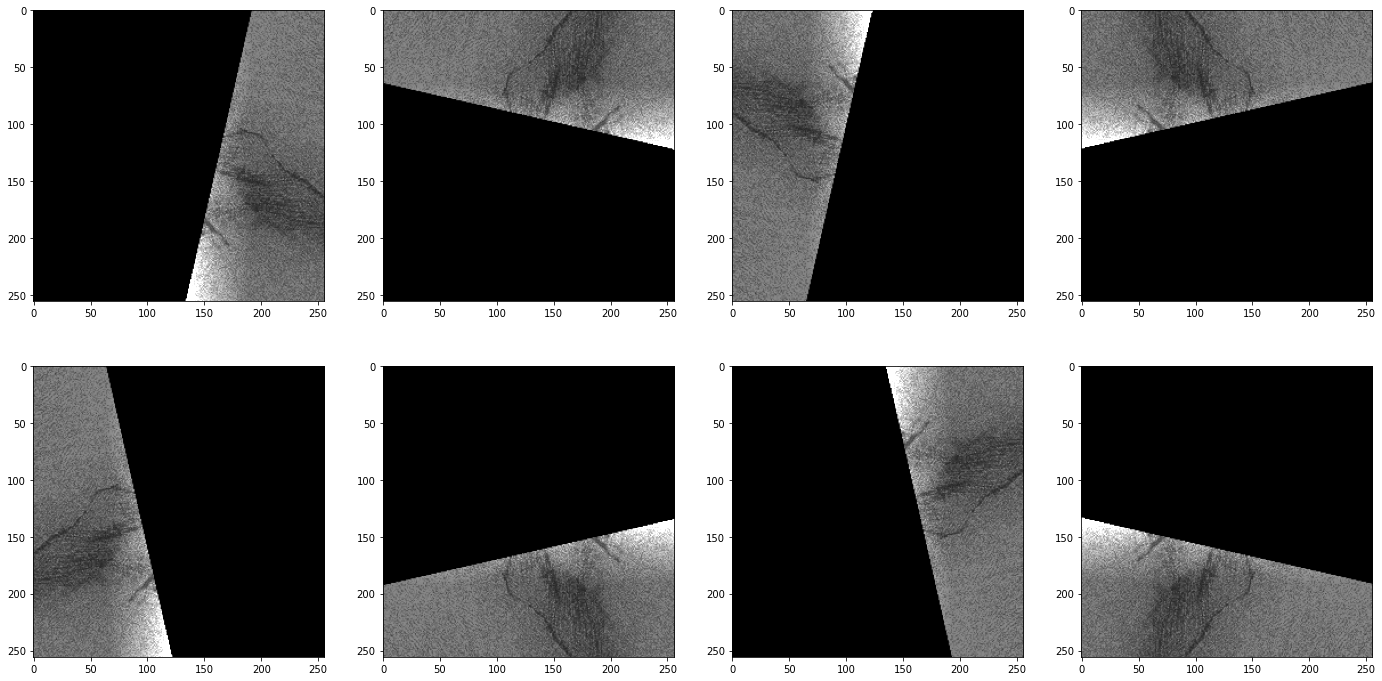

In [9]:
# Visualize the set of 8 augmentations on a random image
img_number = random.randint(0, len(train_x))
print('Image number: ', img_number)
fig = plt.figure(figsize=(24,12))
vmin=np.min(train_x[1])
vmax=np.max(train_x[1])
for i in range(2):
    for j in range(4):
        ax = fig.add_subplot(2, 4, i * 4 + j + 1)
        ax.imshow((AUG[(i*4) + j](image=train_x[img_number])["image"]).astype(np.float64), cmap='gray', vmin=vmin, vmax=vmax)

<a name="One-Hot-Encode"></a>
## 6. One Hot Encode the Masks

In [7]:
print('Before ...')
print('Img type: ', type(train_x), ' img shape: ', train_x.shape, ' element type: ', type(train_x[0][0][0]))
print('Mask type: ', type(train_y), ' mask shape: ', train_y.shape, ' element type: ', type(train_y[0][0][0]))

# expand dimension by 1 such that each image has a classification weight
train_x = np.expand_dims(train_x, axis=3)
train_y = np.expand_dims(train_y, axis=3)
val_x = np.expand_dims(val_x, axis=3)
val_y = np.expand_dims(val_y, axis=3)
test_x = np.expand_dims(test_x, axis=3)
test_y = np.expand_dims(test_y, axis=3)

# one hot encoding the label
train_y_cat = to_categorical(train_y, num_classes=N_CLASSES)
val_y_cat = to_categorical(val_y, num_classes=N_CLASSES)
test_y_cat = to_categorical(test_y, num_classes=N_CLASSES)

output_path = '/content/gdrive/My Drive/Colab Notebooks/Output/seep_detection/'
np.save(output_path + f'test_x_{N_CLASSES}Classes.npy', test_x)
np.save(output_path + f'test_y_{N_CLASSES}Classes.npy', test_y)

print('After ...')
print('Img type: ', type(train_x), ' mask shape: ', train_x.shape, ' element type: ', type(train_x[0][0][0][0]))
print('Mask type: ', type(train_y_cat), ' mask shape: ', train_y_cat.shape, ' element type: ', type(train_y_cat[0][0][0][0]))

# Unique elements of mask: should be [0. 1.] now
print('Unique elements of mask: ' , np.unique(test_y_cat))

if do_cleanup:
  del train_y
  del val_y

Before ...
Img type:  <class 'numpy.ndarray'>  img shape:  (3032, 256, 256)  element type:  <class 'numpy.float64'>
Mask type:  <class 'numpy.ndarray'>  mask shape:  (3032, 256, 256)  element type:  <class 'numpy.uint8'>
After ...
Img type:  <class 'numpy.ndarray'>  mask shape:  (3032, 256, 256, 1)  element type:  <class 'numpy.float64'>
Mask type:  <class 'numpy.ndarray'>  mask shape:  (3032, 256, 256, 8)  element type:  <class 'numpy.float32'>
Unique elements of mask:  [0. 1.]


<a name="Model"></a>
## 7. Define Model: Multi-Class U-Net

The original U-Net model was proposed for biomedical image segmentation applications: https://arxiv.org/pdf/1505.04597.pdf. This is a fully convolutional model that does not include the fully connected classifying layers that often appear in CNNs. Instead, it consists of an initial convolutional encoder that down-samples images to a feature map followed by a convolutional decoder that up samples the feature map back to the input image size. Importantly, the model also includes connections between each decoder and correspondingly-sized encoder layers. This allows the final up-sampling layers to incorporate some of the finer details encoded by the initial decoding layers.  

The authors showed impressive segmentation results for U-Net with a minimal amount of training data. This was possible in large part by combining the model with large amounts of augmented data, as I've done in this study. Moreover, end-to-end training and inference with this model is relatively fast when paired with GPUs. 

In [10]:
def unet_model(n_classes=8, start_neurons=64, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
# original unet model: https://arxiv.org/pdf/1505.04597.pdf
# in original model, start_neurons = 64
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(start_neurons*1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(start_neurons*1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(start_neurons*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(start_neurons*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(start_neurons*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(start_neurons*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(start_neurons*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(start_neurons*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(start_neurons*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(start_neurons*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(start_neurons*8, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(start_neurons*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(start_neurons*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(start_neurons*4, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(start_neurons*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(start_neurons*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(start_neurons*2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(start_neurons*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(start_neurons*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(start_neurons*1, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(start_neurons*1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(start_neurons*1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

<a name="Training"></a>
## 8. Training

In [ ]:
import datetime
my_min_delta = 0.0001
my_patience = 100
my_monitor = 'val_loss'
my_optimizer = 'adam'
my_batch_size = 64
my_epochs = 500
model_type = 'multi_unet'
model_num = 35
# multiplicative factor determining UNet width. When start_neurons == 8, the U-Net encoding stage runs from 8 neurons in the first layer to 128 in the 5th layer
start_neurons=8
# if you have already trained model and want to load h5 file, set this to False
train_model = True
# if loss function is a custom loss function or something native to keras. Default is asymmetric unified focal loss which is custom
is_custom = True
#my_metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
my_metrics = ['accuracy', jacard_coef]
output_path = '/content/gdrive/My Drive/Colab Notebooks/Output/seep_detection/'
log_dir = output_path + "logs/fit/"

# used with one-hot encoded target
#my_loss = 'categorical_crossentropy'
#my_loss = 'sparse_categorical_crossentropy'
#my_loss =  tfa.losses.SigmoidFocalCrossEntropy(gamma=5.)
#dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
#focal_loss = sm.losses.CategoricalFocalLoss()
#my_loss = dice_loss + (1 * focal_loss)

# initial study has shown better 2 class performance with gamma == 0.5 and better 8 class performance with gamma == 0.2 (for asymmetric unified focal loss)
if N_CLASSES == 2:
  my_gamma = 0.5
else:
  my_gamma = 0.2
my_loss = asym_unified_focal_loss(gamma=my_gamma,n_classes=N_CLASSES)
loss_tag = 'asym_unified_focal'


if train_model:
  print("Start Training:")
  model = unet_model(n_classes=N_CLASSES,start_neurons=start_neurons,IMG_HEIGHT=SIZE_Y, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=1)
  model.compile(optimizer=my_optimizer, loss=my_loss, metrics=my_metrics)

  model.summary()
  # write a copy of the model summary to file
  f = open(f'{output_path}model{model_type}_{model_num}_{loss_tag}_summary.txt', 'w')
  model.summary(print_fn = lambda x: f.write(x+'\n'))
  f.close()
  # for tensorboard
  log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = TensorBoard(log_dir = log_dir, histogram_freq = 1, update_freq='epoch', write_images=False)
  #%load_ext tensorboard
  %reload_ext tensorboard

  %tensorboard --logdir logs/fit/
  early_stopping = EarlyStopping(min_delta = my_min_delta, patience = my_patience, monitor = my_monitor, restore_best_weights = True)

  history = model.fit(train_x, train_y_cat, 
                      batch_size = my_batch_size, 
                      verbose=1, 
                      epochs=my_epochs, 
                      shuffle=True,
                      validation_data=(val_x, val_y_cat), 
                      callbacks=[early_stopping, tensorboard_callback])

  model.save(f'{output_path}model{model_type}_{model_num}_{loss_tag}.h5')

else:
  if is_custom:
    model = load_model(f'{output_path}model{model_type}_{model_num}_{loss_tag}.h5', custom_objects={'loss_function': my_loss, 'jacard_coef': jacard_coef } )

  else: 
    model = load_model(f'{output_path}model{model_type}_{model_num}_{loss_tag}.h5')

In [8]:
# for 8 class training, this cleanup stage typically needed to avoid GPU crashing. if training 2 class model or just loading models, this step is not needed
if do_cleanup:
  del val_x, val_y_3d_cat, train_x, train_y_3d_cat

NameError: ignored

<a name="Assessment"></a>
## 9. Performance Assessment

In [11]:
# load best 2 and 8 class models
output_path = '/content/gdrive/My Drive/Colab Notebooks/Output/seep_detection/'
model_loss_2Class = asym_unified_focal_loss(gamma=0.5,n_classes=2)
model_2Class = load_model(f'{output_path}modelmulti_unet_27_asym_unified_focal.h5', custom_objects={'loss_function': model_loss_2Class, 'jacard_coef': jacard_coef } )
model_loss_8Class = asym_unified_focal_loss(gamma=0.2,n_classes=8)
model_8Class = load_model(f'{output_path}modelmulti_unet_30_asym_unified_focal.h5', custom_objects={'loss_function': model_loss_8Class, 'jacard_coef': jacard_coef } )

test_x_2Class = np.load(output_path + f'test_x_2Classes.npy', allow_pickle=True)
test_y_2Class = np.load(output_path + f'test_y_2Classes.npy', allow_pickle=True)
test_x_8Class = np.load(output_path + f'test_x_8Classes.npy', allow_pickle=True)
test_y_8Class = np.load(output_path + f'test_y_8Classes.npy', allow_pickle=True)
# load test data for two models


pred shape:  (10354688,)


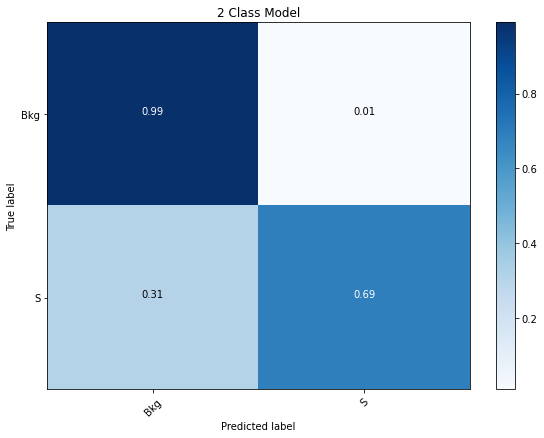

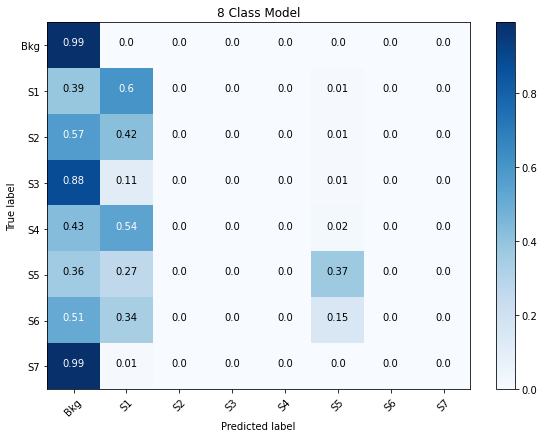

In [39]:
# load 2 class and 8 class test data

pred_y_2Class=model_2Class.predict(test_x_2Class)
pred_y_8Class=model_8Class.predict(test_x_8Class)

names_2Class = ['Bkg', 'S']
names_8Class = ['Bkg', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']

pred_argmax_2Class = np.asarray(pred_y_2Class).argmax(axis=3)
pred_argmax_2Class = pred_argmax_2Class.reshape(pred_argmax_2Class.shape[0]*SIZE_X*SIZE_Y)
print('pred shape: ', pred_argmax_2Class.shape)
test_y_1d_2Class = test_y_2Class.reshape(test_y_2Class.shape[0]*SIZE_X*SIZE_Y)

pred_argmax_8Class = np.asarray(pred_y_8Class).argmax(axis=3)
pred_argmax_8Class = pred_argmax_8Class.reshape(pred_argmax_8Class.shape[0]*SIZE_X*SIZE_Y)
test_y_1d_8Class = test_y_8Class.reshape(test_y_8Class.shape[0]*SIZE_X*SIZE_Y)

cm_2Class = confusion_matrix(test_y_1d_2Class, pred_argmax_2Class)
cm_8Class = confusion_matrix(test_y_1d_8Class, pred_argmax_8Class)

fig_2Class = plot_confusion_matrix(cm_2Class,names_2Class, "2 Class Model")
fig_8Class = plot_confusion_matrix(cm_8Class,names_8Class, "8 Class Model")



In [21]:
test_y_2Class.shape

(158, 256, 256, 1)

In [40]:
def weighted_average(distribution, weights):
  
    numerator = sum([distribution[i]*weights[i] for i in range(len(distribution))])
    denominator = sum(weights)
    
    return round(numerator/denominator,2)


print("2 Class Model ...")
n_classes = 2
test_y_cat_2Class = to_categorical(test_y_2Class, num_classes=n_classes)
test_loss, acc, jacard_loss = model_2Class.evaluate(test_x_2Class, test_y_cat_2Class)
print("Pixel Accuracy:", (acc * 100.0), "%")
print("Jacard Loss: ", jacard_loss)

#IOU
pred_y=model_2Class.predict(test_x_2Class)
pred_y_argmax=np.argmax(pred_y, axis=3)
print('pred shape: ', pred_y_argmax.shape)

IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_y_2Class[:,:,:,0], pred_y_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class_IoU = [] 
class_weights = []

samples_per_class =  np.bincount(test_y_2Class.reshape(-1))

for i in range(n_classes):
  class_weights.append( 1 - (samples_per_class[i] / np.sum(samples_per_class)))

  class_IoU.append( values[i,i] / (values.sum(axis=1)[i] + (values.sum(axis=0)[i] - values[i,i])) )
  pred_str = f'IoU for class {i} is: {class_IoU[i]}'
  print(pred_str)

print('IoU frequency weighted average: ', weighted_average(class_IoU, class_weights))


print("8 Class Model ...")
n_classes = 8
test_y_cat_8Class = to_categorical(test_y_8Class, num_classes=n_classes)
test_loss, acc, jacard_loss = model_8Class.evaluate(test_x_8Class, test_y_cat_8Class)
print("Pixel Accuracy:", (acc * 100.0), "%")
print("Jacard Loss: ", jacard_loss)

#IOU
pred_y=model_8Class.predict(test_x_8Class)
pred_y_argmax=np.argmax(pred_y, axis=3)


IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_y_8Class[:,:,:,0], pred_y_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class_IoU = [] 
class_weights = []

samples_per_class =  np.bincount(test_y_8Class.reshape(-1))

for i in range(n_classes):
  class_weights.append( 1 - (samples_per_class[i] / np.sum(samples_per_class)))

  class_IoU.append( values[i,i] / (values.sum(axis=1)[i] + (values.sum(axis=0)[i] - values[i,i])) )
  pred_str = f'IoU for class {i} is: {class_IoU[i]}'
  print(pred_str)

print('IoU frequency weighted average: ', weighted_average(class_IoU, class_weights))


2 Class Model ...
5/5 [==============================] - 0s 32ms/step - loss: 0.1743 - accuracy: 0.9888 - jacard_coef: 0.9773
Pixel Accuracy: 98.88200163841248 %
Jacard Loss:  0.9773280024528503
pred shape:  (158, 256, 256)
Mean IoU = 0.73917836
IoU for class 0 is: 0.9886988401412964
IoU for class 1 is: 0.48965781927108765
IoU frequency weighted average:  0.5
8 Class Model ...
7/7 [==============================] - 0s 49ms/step - loss: 0.4356 - accuracy: 0.9851 - jacard_coef: 0.9574
Pixel Accuracy: 98.50766062736511 %
Jacard Loss:  0.9573602676391602
Mean IoU = 0.19499826
IoU for class 0 is: 0.9870866537094116
IoU for class 1 is: 0.3695049285888672
IoU for class 2 is: 0.0
IoU for class 3 is: 0.0
IoU for class 4 is: 0.00410810811445117
IoU for class 5 is: 0.19916655123233795
IoU for class 6 is: 0.00011984659795416519
IoU for class 7 is: 0.0
IoU frequency weighted average:  0.08


In [60]:
n_test_events = 5

n_test_imgs = test_x_2Class.shape[0]
n_classes = 2
prediction_2Class = (model_2Class.predict(test_x_2Class))
prediction = np.reshape(prediction_2Class,(n_test_imgs,SIZE_X,SIZE_Y,n_classes))
n_classes = 8
prediction_8Class = (model_2Class.predict(test_x_8Class))
prediction_8Class = np.reshape(prediction_8Class,(n_test_imgs,SIZE_X,SIZE_Y,n_classes))

for i in range(n_test_events):
  img_number = random.randint(0, len(test_x))
  print('img: ', img_number)
  pred_2Class = np.argmax(prediction_2Class, axis=3)[img_number,:,:]
  pred_8Class = np.argmax(prediction_8Class, axis=3)[img_number,:,:]
  img = test_x_2Class[img_number,:,:,0]
  target = test_y_8Class[img_number,:,:,0]

  visualize_img_target_pred2_pred8(img, target, pred_2Class, pred_8Class)

ValueError: ignored